In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, plot_roc_curve

from xgboost import XGBClassifier

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

## EDA
---

### Read in Data

In [2]:
b4anchor = pd.read_csv('./data/b4timeanchor.csv')
afteranchor = pd.read_csv('./data/aftertimeanchor.csv')

# join both datasets, set unique indices
df = pd.concat([b4anchor, afteranchor])
df.reset_index(drop=True, inplace=True)
df.shape

C:\Users\leejl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,1,9,10,19,22,25,26,28,29,42,56,69,72,73,74,75,76,77,78,79,80,82,83,84,86,89,90,92,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42598, 96)

### Drop Superfluous Columns, Deleted Posts, and Posts Removed by Moderators

In [3]:
# drop 91 columns of unneccessary data
df = df[['subreddit', 'title', 'removed_by_category', 'banned_by']]

In [4]:
# drop posts that generated user bans
df = df.loc[df['banned_by'] != 'moderators', :]

# drop deleted posts and posts removed by moderators
df = df.loc[(df['removed_by_category'] != 'deleted')
            & (df['removed_by_category'] != 'moderator')
            & (df['removed_by_category'] != 'automod_filtered')
            & (df['removed_by_category'] != 'author'), :]

# check dataframe shape
df.shape

(38170, 4)

### Investigate Stopwords Specific to This Data


Most of these posts are questions, likely respresented in similar ratios in each subreddit, so certain question words like "why" and "how" will likely impart no meaning when classifying. CountVectorizer tokenizes and counts words, so lets use it hunt down extra stopwords unique to this corpus instead of manually breaking every document apart and counting tokens.

In [5]:
# multiple CountVectorizer objects are needed to compare word frequencies between classes

# initializing vectorizers with the NLTK default stopwords to avoid 
cvec = CountVectorizer(strip_accents='ascii', stop_words=stopwords.words('english'))
shitty_cvec = CountVectorizer(strip_accents='ascii', stop_words=stopwords.words('english'))

# implement the vectorizers
word_counts = cvec.fit_transform(df.loc[df['subreddit'] == 'askscience', 'title'])
shitty_word_counts = shitty_cvec.fit_transform(df.loc[df['subreddit'] == 'shittyaskscience', 'title'])

# take a look at how many features this created
print(len(cvec.get_feature_names()))
print(len(shitty_cvec.get_feature_names()))

15430
16974


In [6]:
# turn the transformed objects back in to dataframes
word_counts = pd.DataFrame(word_counts.toarray(), columns = cvec.get_feature_names())
shitty_word_counts = pd.DataFrame(shitty_word_counts.toarray(), columns = shitty_cvec.get_feature_names())

# take a quick gander
word_counts.head()

,00,000,000km,000mph,001m,00361445,01,01m,0210,029,...,zooming,zooniotic,zooniverse,zoonosis,zoonotic,zooplankton,zoos,zoosones,zygote,zygotes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# finding the most common shared words between subreddits

high_use = word_counts.sum().sort_values(ascending = False).head(100)
shitty_high_use = shitty_word_counts.sum().sort_values(ascending = False).head(100)

# make a list of shared high-use words in both subreddits for custom stopwords,
# but only if their usage frequencies have a percent difference of less than 20%
custom_stop_words = [i for i in high_use.index if i in shitty_high_use.index
                     and (np.abs(word_counts[i].value_counts()[1] - shitty_word_counts[i].value_counts()[1]) /
                     ((word_counts[i].value_counts()[1] + shitty_word_counts[i].value_counts()[1]) / 2))
                     < .2]

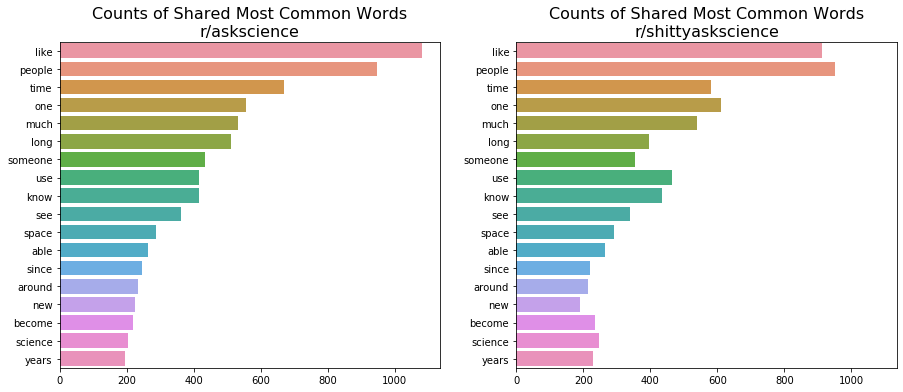

In [8]:
# plot our new corpus-specific stopwords

plt.figure(figsize = (15, 6))

ax1 = plt.subplot(121)
sns.barplot(high_use[custom_stop_words], high_use[custom_stop_words].index)
plt.title('Counts of Shared Most Common Words\nr/askscience', fontdict={'fontsize': 16})

ax2 = plt.subplot(122, sharex=ax1)
sns.barplot(shitty_high_use[custom_stop_words], shitty_high_use[custom_stop_words].index)
plt.title('Counts of Shared Most Common Words\nr/shittyaskscience', fontdict={'fontsize': 16});

plt.savefig('./figures/custom_stop_words.jpeg')

The CountVectorizer documentation warns about using custom stop words, as they will not be subjected to the vectorizer's internal preprocessing steps. All stop words need to be stemmed manually and appended to a master list of stop words for thorough testing.

In [9]:
# initialize list for all stopwords
all_the_stops = []

# fill it with the unstemmed custom_stop_words
all_the_stops.extend(custom_stop_words)

# initialize stemmer, stem custom_stop_words, append them to all_the_stops
stem = PorterStemmer()
stem_stop_words = [stem.stem(i) for i in custom_stop_words]
all_the_stops.extend(stem_stop_words)

# add the default NLTK stopwords to all_the_stops
nltk_stopwords = stopwords.words('english')
all_the_stops.extend(nltk_stopwords)

# stem the default NLTK stopwords and append them to all_the_stops
stem_nltk_stopwords = [stem.stem(i) for i in nltk_stopwords]
all_the_stops.extend(stem_nltk_stopwords)

### Word Counts

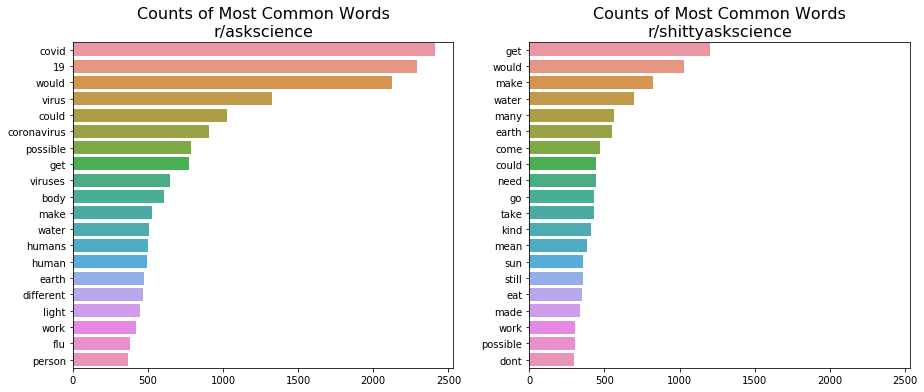

In [10]:
# plots of word counts after removing custom_stop_words

plt.figure(figsize = (15, 6))

ax1 = plt.subplot(121)
sns.barplot(high_use.drop(custom_stop_words).head(20), high_use.drop(custom_stop_words).head(20).index)
plt.title('Counts of Most Common Words\nr/askscience', fontdict={'fontsize': 16})

ax2 = plt.subplot(122, sharex=ax1)
sns.barplot(shitty_high_use.drop(custom_stop_words).head(20), shitty_high_use.drop(custom_stop_words).head(20).index)
plt.title('Counts of Most Common Words\nr/shittyaskscience', fontdict={'fontsize': 16});

plt.savefig('./figures/common_words.jpeg')

## Modeling
---

Note: GridSearch hyperparameters in all models have been weened to reasonable subsets of original testing values.

### Functions for Models

With the right parameters, CountVectorizer can implement many different preprocessing steps. For instance, this data is loaded with numbers and non-ASCII characters that should be removed, and CountVectorizer can do that. Models should also be tested with stemmed tokens, and that can be accomplished with a tiny function passed to CountVectorizer. Lemmatizing proved fruitless.

In [11]:
# stemmer
def cv_stemmer(word):
    stem = PorterStemmer()
    return stem.stem(word)

# DenseTransformer from Brendan McDonnell and http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

# regex pattern to nix numbers
only_words_token_pattern = '[a-zA-Z]{2,}'

# metrics
def get_scores(model, X_train, X_test):
    
    # confusion matrix, sensitivity, specificity
    train_preds = model.predict(X_train)
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    
    # scores
    print('Training Accuracy:', round(cross_val_score(model, X_train, y_train).mean(), 5))
    print('Testing Accuracy:', round(model.score(X_test, y_test), 5))
    print('Sensitivity:', round(sens, 5))
    print('Specificity:', round(spec, 5))
    
    # ROC curve
    plt.figure()
    plot_roc_curve(model, X_test, y_test)
    plt.title('ROC Curve', fontdict={'fontsize': 16})
    plt.plot([0,1], [0,1])
    
    return pd.DataFrame(cm, columns=['Actual Negative', 'Actual Positive'], index=['Predicted Negative', 'Predicted Positive'])

### Binarize Target, Base Model, train_test_split

In [12]:
# posts from r/askscience will represent the positive class
df.replace({'askscience': 1, 'shittyaskscience': 0}, inplace=True)

# check target balance
df['subreddit'].value_counts(normalize=True)

0    0.520828
1    0.479172
Name: subreddit, dtype: float64

In [13]:
# train test split data
X = df['title']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### K-Nearest Neighbors

{'cvec__max_features': 4500, 'cvec__stop_words': ['like', 'people', 'time', 'one', 'much', 'long', 'someone', 'use', 'know', 'see', 'space', 'able', 'since', 'around', 'new', 'become', 'science', 'years', 'like', 'peopl', 'time', 'one', 'much', 'long', 'someon', 'use', 'know', 'see', 'space', 'abl', 'sinc', 'around', 'new', 'becom', 'scienc', 'year', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into

,Actual Negative,Actual Positive
Predicted Negative,4667,251
Predicted Positive,2885,1740


<Figure size 432x288 with 0 Axes>

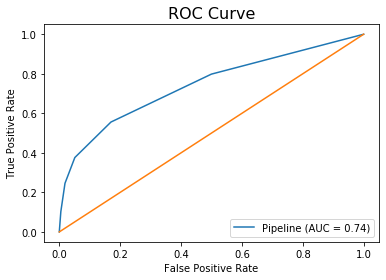

In [14]:
knn_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

knn_params = {
    'cvec__strip_accents': ['ascii'],
    'cvec__stop_words': [all_the_stops],
    'cvec__max_features': [4500],
}

gs_knn = GridSearchCV(knn_pipe, knn_params, n_jobs = 4, cv = 5)
gs_knn.fit(X_train, y_train)

print(gs_knn.best_params_)
get_scores(gs_knn.best_estimator_, X_train, X_test)

### Multinomial Naive Bayes with CountVectorizer

{'cvec__max_features': 7300, 'cvec__preprocessor': <function cv_stemmer at 0x000001E4D6402708>, 'cvec__strip_accents': 'ascii', 'cvec__token_pattern': '[a-zA-Z]{2,}'}
Training Accuracy: 0.82321
Testing Accuracy: 0.82113
Sensitivity: 0.77449
Specificity: 0.86499


,Actual Negative,Actual Positive
Predicted Negative,4254,664
Predicted Positive,1043,3582


<Figure size 432x288 with 0 Axes>

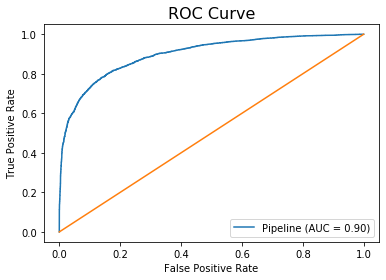

In [15]:
mnb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

mnb_params = {
    'cvec__strip_accents': ['ascii'],
    'cvec__preprocessor': [cv_stemmer],
    'cvec__token_pattern': [only_words_token_pattern],
    'cvec__max_features': [7300],
}

gs_mnb = GridSearchCV(mnb_pipe, mnb_params, n_jobs = -1, cv = 5)
gs_mnb.fit(X_train, y_train)

print(gs_mnb.best_params_)
get_scores(gs_mnb.best_estimator_, X_train, X_test)

### Gaussian Naive Bayes with TfidfVectorizer

{'tvec__max_features': 4300, 'tvec__preprocessor': <function cv_stemmer at 0x000001E4D6402708>, 'tvec__strip_accents': 'ascii'}
Training Accuracy: 0.75327
Testing Accuracy: 0.75972
Sensitivity: 0.64995
Specificity: 0.86295


,Actual Negative,Actual Positive
Predicted Negative,4244,674
Predicted Positive,1619,3006


<Figure size 432x288 with 0 Axes>

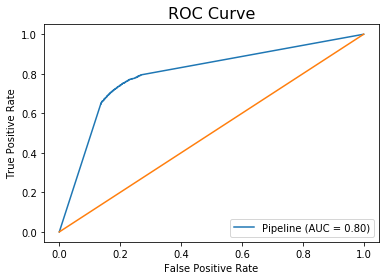

In [16]:
gnb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('dt', DenseTransformer()),
    ('gnb', GaussianNB())
])

gnb_params = {
    'tvec__strip_accents': ['ascii'],
    'tvec__preprocessor': [cv_stemmer],
    'tvec__max_features': [4300],
}

gs_gnb = GridSearchCV(gnb_pipe, gnb_params, n_jobs = 4, cv = 5)
gs_gnb.fit(X_train, y_train)

print(gs_gnb.best_params_)
get_scores(gs_gnb.best_estimator_, X_train, X_test)

### Complement Naive Bayes with CountVectorizer

{'cvec__max_features': 10000, 'cvec__preprocessor': <function cv_stemmer at 0x000001E4D6402708>, 'cvec__strip_accents': 'ascii'}
Training Accuracy: 0.8245
Testing Accuracy: 0.82364
Sensitivity: 0.78292
Specificity: 0.86194


,Actual Negative,Actual Positive
Predicted Negative,4239,679
Predicted Positive,1004,3621


<Figure size 432x288 with 0 Axes>

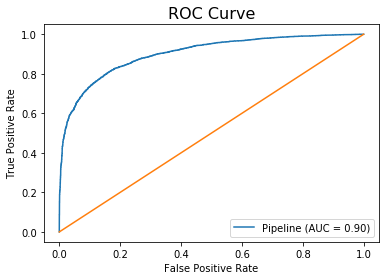

In [17]:
cnb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('cnb', ComplementNB())
])

cnb_params = {
    'cvec__strip_accents': ['ascii'],
    'cvec__preprocessor': [cv_stemmer],
    'cvec__max_features': [10000],
}

gs_cnb = GridSearchCV(cnb_pipe, cnb_params, n_jobs = -1, cv = 5)
gs_cnb.fit(X_train, y_train)

print(gs_cnb.best_params_)
get_scores(gs_cnb.best_estimator_, X_train, X_test)

### Logistic Regression with TfidfVectorizer

{'tvec__max_features': 7300, 'tvec__preprocessor': <function cv_stemmer at 0x000001E4D6402708>, 'tvec__strip_accents': 'ascii'}
Training Accuracy: 0.82544
Testing Accuracy: 0.82783
Sensitivity: 0.79503
Specificity: 0.85868


,Actual Negative,Actual Positive
Predicted Negative,4223,695
Predicted Positive,948,3677


<Figure size 432x288 with 0 Axes>

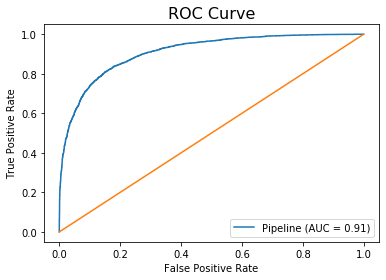

In [18]:
lr_pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

lr_params_tvec = {
    'tvec__strip_accents': ['ascii'],
    'tvec__preprocessor': [cv_stemmer],
    'tvec__max_features': [7300],
}

gs_lr_tvec = GridSearchCV(lr_pipe_tvec, lr_params_tvec, n_jobs = -1, cv = 5)
gs_lr_tvec.fit(X_train, y_train)

print(gs_lr_tvec.best_params_)
get_scores(gs_lr_tvec.best_estimator_, X_train, X_test)

### Ridge Classifier

{'tvec__max_features': 9000, 'tvec__preprocessor': <function cv_stemmer at 0x000001E4D6402708>, 'tvec__strip_accents': 'ascii', 'tvec__token_pattern': '[a-zA-Z]{2,}'}
Training Accuracy: 0.82625
Testing Accuracy: 0.82815
Sensitivity: 0.80043
Specificity: 0.85421


,Actual Negative,Actual Positive
Predicted Negative,4201,717
Predicted Positive,923,3702


<Figure size 432x288 with 0 Axes>

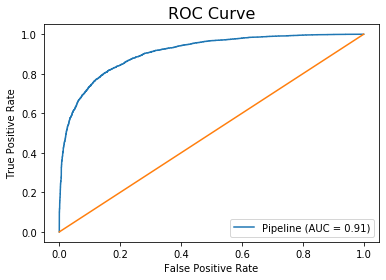

In [19]:
ridge_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ridge', RidgeClassifier())
])

ridge_params = {
    'tvec__strip_accents': ['ascii'],
    'tvec__preprocessor': [cv_stemmer],   
    'tvec__token_pattern': [only_words_token_pattern],
    'tvec__max_features': [9000],
}

gs_ridge = GridSearchCV(ridge_pipe, ridge_params, n_jobs = -1, cv = 5)
gs_ridge.fit(X_train, y_train)

print(gs_ridge.best_params_)
get_scores(gs_ridge.best_estimator_, X_train, X_test)

### Perceptron

{'perceptron__penalty': None, 'tvec__max_features': 7000, 'tvec__preprocessor': <function cv_stemmer at 0x000001E4D6402708>, 'tvec__strip_accents': 'ascii'}
Training Accuracy: 0.78077
Testing Accuracy: 0.78717
Sensitivity: 0.76238
Specificity: 0.81049


,Actual Negative,Actual Positive
Predicted Negative,3986,932
Predicted Positive,1099,3526


<Figure size 432x288 with 0 Axes>

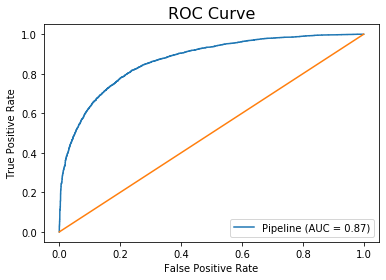

In [20]:
perceptron_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('perceptron', Perceptron())
])

perceptron_params = {
    'tvec__strip_accents': ['ascii'],
    'tvec__preprocessor': [cv_stemmer],    
    'tvec__max_features': [7000],
    'perceptron__penalty': [None]
}

gs_perceptron = GridSearchCV(perceptron_pipe, perceptron_params, n_jobs = -1, cv = 5)
gs_perceptron.fit(X_train, y_train)

print(gs_perceptron.best_params_)
get_scores(gs_perceptron.best_estimator_, X_train, X_test)

### LinearSVC

{'svc__C': 0.06, 'tvec__max_features': 8200, 'tvec__preprocessor': <function cv_stemmer at 0x000001E4D6402708>, 'tvec__strip_accents': 'ascii', 'tvec__token_pattern': '[a-zA-Z]{2,}'}
Training Accuracy: 0.82359
Testing Accuracy: 0.8249
Sensitivity: 0.78659
Specificity: 0.86092


,Actual Negative,Actual Positive
Predicted Negative,4234,684
Predicted Positive,987,3638


<Figure size 432x288 with 0 Axes>

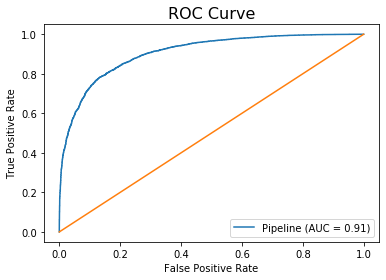

In [21]:
svc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', LinearSVC())
])

svc_params = {
    'tvec__strip_accents': ['ascii'],
    'tvec__preprocessor': [cv_stemmer],    
    'tvec__token_pattern': [only_words_token_pattern],
    'tvec__max_features': [8200],
    'svc__C': [.06]
}

gs_svc = GridSearchCV(svc_pipe, svc_params, n_jobs = -1, cv = 5)
gs_svc.fit(X_train, y_train)

print(gs_svc.best_params_)
get_scores(gs_svc.best_estimator_, X_train, X_test)

### XGBoost

{'cvec__max_features': 5000, 'cvec__preprocessor': <function cv_stemmer at 0x000001E4D6402708>, 'cvec__strip_accents': 'ascii', 'cvec__token_pattern': '[a-zA-Z]{2,}', 'xgb__colsample_bytree': 0.4, 'xgb__gamma': 0.2, 'xgb__learning_rate': 0.5, 'xgb__max_depth': 20, 'xgb__min_child_weight': 1}
Training Accuracy: 0.82062
Testing Accuracy: 0.81452
Sensitivity: 0.77708
Specificity: 0.84974


,Actual Negative,Actual Positive
Predicted Negative,4179,739
Predicted Positive,1031,3594


<Figure size 432x288 with 0 Axes>

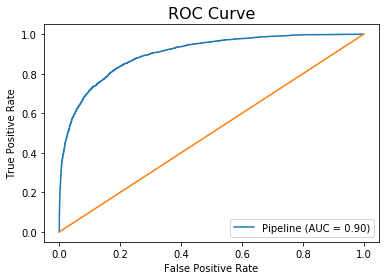

In [22]:
xgb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', XGBClassifier())
])

xgb_params = {
    'cvec__strip_accents': ['ascii'],
    'cvec__preprocessor': [cv_stemmer],
    'cvec__token_pattern': [only_words_token_pattern],
    'cvec__max_features': [5000],
    'xgb__learning_rate': [0.5],
    'xgb__max_depth': [20],
    'xgb__min_child_weight':[1],
    'xgb__gamma':[0.2],
    'xgb__colsample_bytree': [0.4]
}

gs_xgb = GridSearchCV(xgb_pipe, xgb_params, n_jobs = -1, cv = 5)
gs_xgb.fit(X_train, y_train)

print(gs_xgb.best_params_)
get_scores(gs_xgb.best_estimator_, X_train, X_test)

## Model Metric Comparison
---

In [23]:
# Model Performance Comparison, building a dataframe with metrics

models = {'knn': gs_knn.best_estimator_,
          'mnb': gs_mnb.best_estimator_,
          'gnb': gs_gnb.best_estimator_,
          'cnb': gs_cnb.best_estimator_,
          'lr': gs_lr_tvec.best_estimator_,
          'ridge': gs_ridge.best_estimator_,
          'perceptron': gs_perceptron.best_estimator_,
          'svc': gs_svc.best_estimator_, 
          'xgb': gs_xgb.best_estimator_}

In [24]:
model_names = []
metrics_list = []
    
for key, value in models.items():

    # sensitivity, specificity
    preds = value.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)

    # scores
    training_acc = round(cross_val_score(value, X_train, y_train).mean(), 5)
    testing_acc = round(value.score(X_test, y_test), 5)
    sensitivity = round(sens, 5)
    specificity = round(spec, 5)

    model_performance = {
        'Training': training_acc,
        'Testing': testing_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
    }

    model_names.append(key)
    metrics_list.append(model_performance)

In [25]:
scores_df = pd.DataFrame(metrics_list)
scores_df.rename({i:j for i, j in enumerate(model_names)}, inplace=True)

In [26]:
scores_df

,Training,Testing,Sensitivity,Specificity
knn,0.66430,0.67138,0.37622,0.94896
mnb,0.82321,0.82113,0.77449,0.86499
gnb,0.75327,0.75972,0.64995,0.86295
cnb,0.82450,0.82364,0.78292,0.86194
lr,0.82544,0.82783,0.79503,0.85868
ridge,0.82625,0.82815,0.80043,0.85421
perceptron,0.78077,0.78717,0.76238,0.81049
svc,0.82359,0.82490,0.78659,0.86092
xgb,0.82062,0.81452,0.77708,0.84974


## Most Divisive Words
---

In [27]:
# recreate best logistic regression model

tfidf = TfidfVectorizer(strip_accents = 'ascii', preprocessor = cv_stemmer, max_features = 7300)

X_train_tv = tfidf.fit_transform(X_train)
X_test_tv = tfidf.transform(X_test)

logreg = LogisticRegression()

logreg.fit(X_train_tv, y_train)

# pull coefficients for features/words
coefficients = pd.DataFrame(list(zip(logreg.coef_[0],tfidf.get_feature_names())))

# look at 50 features whose presence is most likely to result in a classification of 0
coefficients.sort_values(by=0).head(50)

,0,1
6552,-7.991293,this
6534,-4.045678,these
4291,-4.035487,my
2764,-3.595562,gay
3238,-3.574293,if
5276,-3.267465,reddit
3029,-3.120725,he
4882,-2.896153,poop
5760,-2.851187,shit
3532,-2.710426,just


In [28]:
# look at 50 features whose presence is most likely to result in a classification of 1
coefficients.sort_values(by=0, ascending=False).head(50)

,0,1
1512,6.848755,covid
7006,6.004056,viruses
27,5.878905,19
7005,5.421539,virus
1471,5.163611,coronavirus
1513,4.735301,covid19
4619,4.194386,pandemic
227,3.851877,affect
3977,3.675294,masks
2577,3.512712,flu


## Investigating Misclassified Posts
---

In [29]:
# generate predictions
test_preds = logreg.predict(X_test_tv)

# match them to post titles
results = pd.DataFrame({
    'titles': X_test,
    'predicted_subreddit': test_preds,
    'actual_subreddit': y_test})

# filter out accurate predictions from misclassifications
accurate_predictions = results.loc[results['predicted_subreddit'] == results['actual_subreddit'], :]
misclassifications = results.loc[results['predicted_subreddit'] != results['actual_subreddit'], :]

#### A Sample of True Positives

In [30]:
print(accurate_predictions.loc[accurate_predictions['actual_subreddit'] == 1, 'titles'].values[:10])

["Is it possible that, sometime in the future, there could be a brain implant that allowed full-time internet access? Like you can look up stuff with your mind? O don't feel like it's possible"
 'I’m time traveling back to 1920. Would my immune system be so set on tackling other “modern” bacterias that I would die?'
 'How much of an exposure to COVID-19 virus leads to an infection?'
 'Why does Corona infects only humans and not other animals?'
 'How do grass and plants grow back after a fire since there will be no seeds without any plants?'
 'How do hand sanitizers work? (in chemistry terms)'
 'Can a fertilized octopus egg ingested into the human system actually grow inside the body?'
 'Bodies on eath have potential energy because of the force of gravity acting on them. If you apply a force on something(like pushing it), does it gain potential energy?'
 'Why is are some many people A-symptomatic with COVID 19?'
 'How sure can we be that SARS-CoV-2 is of natural origin?']


#### A Sample of False Positives

In [31]:
print(misclassifications.loc[misclassifications['actual_subreddit'] != 1, 'titles'].values[:10])

['What is the difference between neural nets and fishing nets?'
 'Are moths attracted to light or scared of the dark?'
 'What would taking a bath in carbonated water feel like?'
 'Would a normal window be strong enough or be able to gain enough speed/force to cleanly decapitate someone like it does in the movies and on TV?'
 'How do i do a handstand on the surface?'
 'What would happen if you go outside and back in real quick in a t-shirt and shorts in the coldest part of the world?'
 "CRISPER technology for genetically modifying organisms has been around for some time, but my cornflakes still get soggy. What's up with that?"
 'What temperature would be required to melt a human being? On top of that, what temperature would be required to sublimate a human being?'
 'Is "10" pronounced "onety" or "zeroteen"?'
 'Computers, email, and digitally stored information has greatly reduced the amount of paper products used, which helps the environment significantly. How can we use that same conce

#### A Sample of True Negatives

In [32]:
print(accurate_predictions.loc[accurate_predictions['actual_subreddit'] != 1, 'titles'].values[:10])

['Why do we have a test to see if he is the father, but not if the baby is his child? 👶'
 'Corn’s hidden uses'
 'How common is this birth defect for a person to have 3 left hands?'
 "If I'm having suicidal thoughts and then kill myself in order to save my own life from being murdered by me, would the law protect me?"
 'My car is almost 16 years old, will it become a self driving car?'
 'How many marmots are in an universal standard marmoset?'
 "AskAscience deleted this but I want a serious question dammit! Suppose a mad scientist takes over the world and decides to devote all of mankind's resources towards destroying the sun! Why? Mad scientist. What technology should be pursued which has the best chance of actually doing this?"
 'If almonds are nuts, how can they produce milk? Are almond trees hermaphrodites?'
 'With so many options of renewable energy, why are we still using oil?'
 'If prolonged exposure to the sun can cause skin cancer, and radiation is used to fight cancer, should 

#### A Sample of False Negatives

In [33]:
print(misclassifications.loc[misclassifications['actual_subreddit'] == 1, 'titles'].values[:10])

['Help me with my qualifying exam?'
 "why don't mesons annihilate, and how do they even exist?"
 "[Physics] Why can I spot tiny glimmers of colored light on my dog's fur on a sunny day?"
 'How much energy (in kJs) is needed for a plant to grow?'
 'Is yellowstone going to erupt this week? or anytime soon?'
 'Why RNA has Uracil instead of Thyamine?'
 'Say we have two 20 year old identical twins. If one was put on a spacecraft that travelled at 99.99% light speed through space and came back to Earth after 40 years, what would he look like in comparison to his twin brother who lived those 40 years on Earth?'
 'How long until this dies down in the uk?'
 'Why do people become less willing to change and adapt as they age?'
 'Name of a Primitive People Believing sperm is finite and to replenish They must lick a white leaking liquid from a Tree?']
